In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import sklearn as sk
from PIL import Image, ImageOps, ImageDraw

2024-05-23 20:24:52.912207: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 20:24:52.948540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 20:24:53.464285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the binary file
binary_file = 'games.npz'
data = np.load(binary_file, allow_pickle=True)

images = data['images']
images.astype('float32')
labels = data['labels']
label_names = data['label_names']


df = pd.DataFrame({
    'image': list(images),
    'label': labels
})
df['label'] = labels

In [3]:
def crop_image(image, crop_size=10):

    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    img_pil = Image.fromarray(image)
    width, height = img_pil.size
    
    cropped_img = img_pil.crop((crop_size, crop_size, width - crop_size, height - crop_size))
    return np.array(cropped_img)

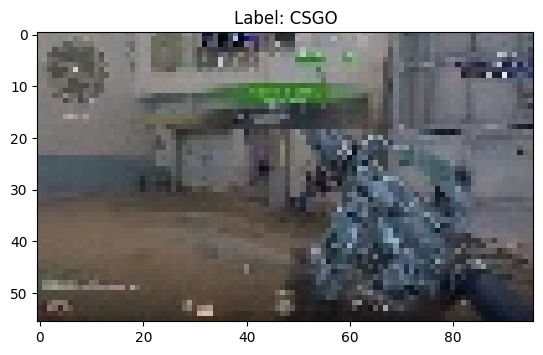

array([[[0.5686275 , 0.54509807, 0.5176471 ],
        [0.5686275 , 0.5568628 , 0.5254902 ],
        [0.5529412 , 0.53333336, 0.52156866],
        ...,
        [0.3764706 , 0.38039216, 0.43529412],
        [0.43137255, 0.44705883, 0.49019608],
        [0.38431373, 0.4       , 0.44313726]],

       [[0.57254905, 0.54901963, 0.52156866],
        [0.5568628 , 0.5411765 , 0.52156866],
        [0.5372549 , 0.5254902 , 0.50980395],
        ...,
        [0.35686275, 0.37254903, 0.41568628],
        [0.38039216, 0.4       , 0.43529412],
        [0.31764707, 0.34509805, 0.38039216]],

       [[0.5372549 , 0.52156866, 0.5019608 ],
        [0.5647059 , 0.54901963, 0.5294118 ],
        [0.54901963, 0.5372549 , 0.52156866],
        ...,
        [0.3529412 , 0.38431373, 0.4117647 ],
        [0.40784314, 0.44313726, 0.45882353],
        [0.3882353 , 0.43137255, 0.44705883]],

       ...,

       [[0.24313726, 0.18039216, 0.18431373],
        [0.21176471, 0.15294118, 0.14509805],
        [0.5411765 , 0

In [4]:
example = images[1]
plt.imshow(example, cmap='gray')
plt.title(f"Label: {label_names[labels[0]]}")
plt.show()
example

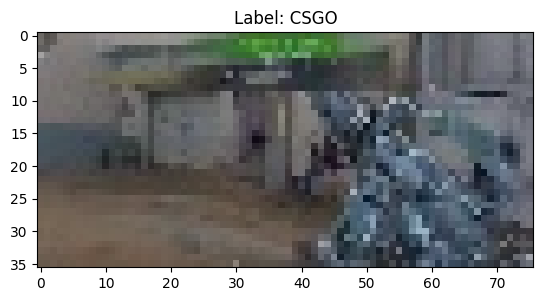

In [5]:
example1 = crop_image(example, 10)
plt.imshow(example1, cmap='gray')
plt.title(f"Label: {label_names[labels[0]]}")
plt.show()

In [6]:
len(df['image'])

84447

In [7]:
print(labels)

[0 0 0 ... 6 6 6]


In [8]:
def sample(images, labels, num_samples_per_class):
    selected_images = []
    selected_labels = []
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        selected_indices = np.random.choice(indices, num_samples_per_class, replace=False)
        selected_images.extend(images[selected_indices])
        selected_labels.extend(labels[selected_indices])
    
    return np.array(selected_images), np.array(selected_labels)

In [9]:
num_samples_per_class = 4000
images, labels = sample(images, labels, num_samples_per_class)

In [10]:
print(len(images))

28000


In [11]:
images_with_hidden_part = np.array([crop_image(img, 10) for img in images])
df = pd.DataFrame({
    'image': list(images_with_hidden_part),
    'label': labels
})

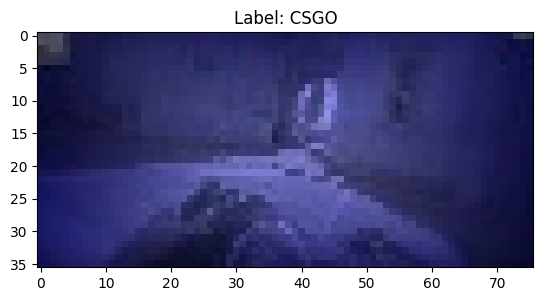

In [12]:
example_image_with_hidden_edges = images_with_hidden_part[0]
plt.imshow(example_image_with_hidden_edges, cmap='gray')
plt.title(f"Label: {label_names[labels[0]]}")
plt.show()

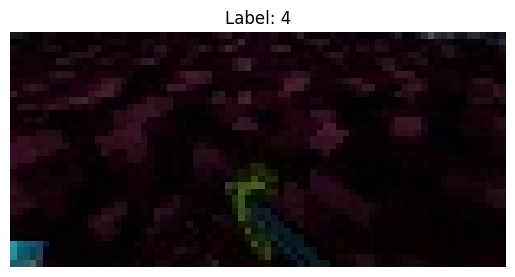

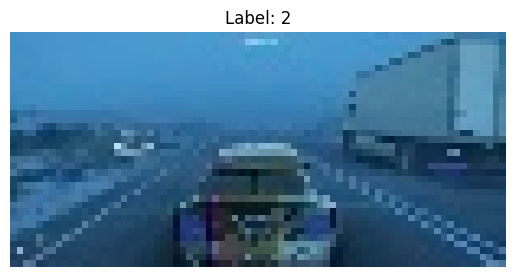

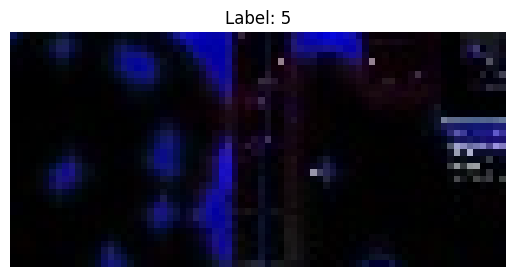

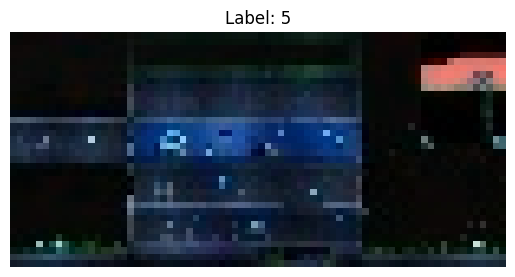

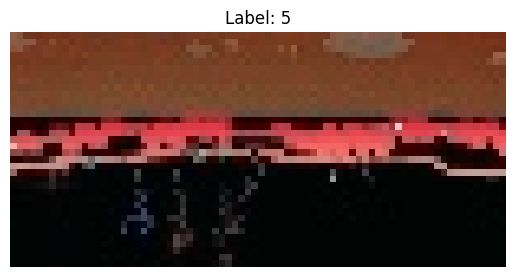

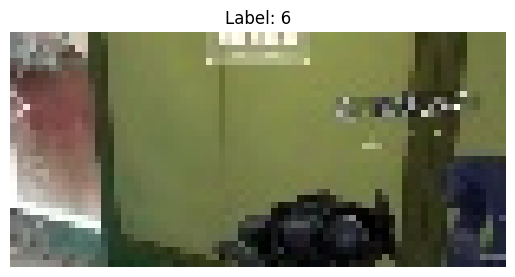

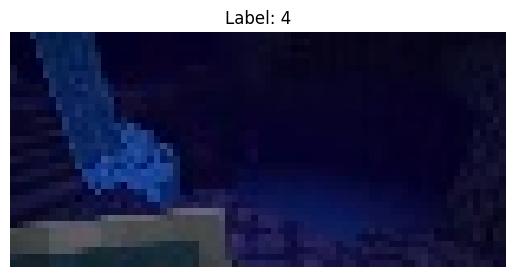

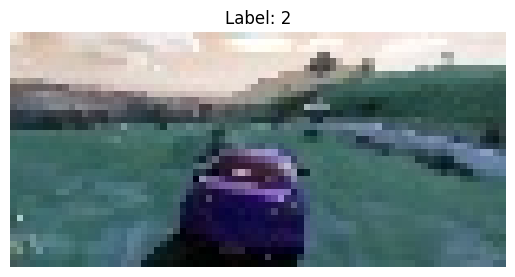

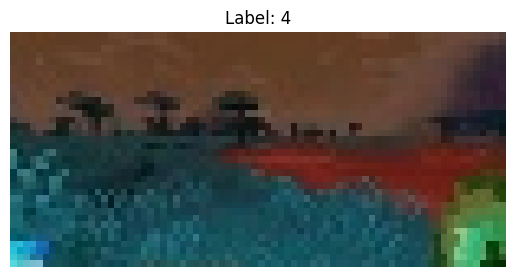

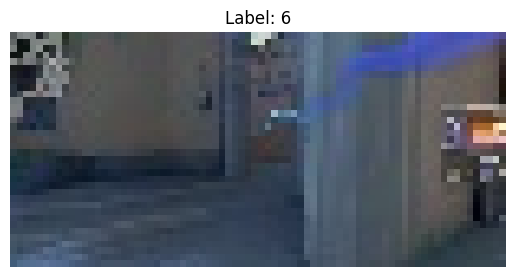

In [13]:
df = df.sample(frac=1).reset_index(drop=True)

for elt in range(10):
    # Display the first image
    first_image = df['image'].iloc[elt]
    first_label = df['label'].iloc[elt]

    plt.imshow(first_image)
    plt.title(f'Label: {first_label}')
    plt.axis('off')  # Hide the axis
    plt.show()

In [30]:
num_classes = len(np.unique(labels))
categorical = to_categorical(labels, num_classes)
categorical

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(images, categorical, test_size=0.2, random_state=42)

In [32]:
def Cnn_model(input_shape: tuple, num_classes: int):
    model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(images.shape[1], images.shape[2], images.shape[3])),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [33]:
def train_model(model, x: np.array, y: np.array,
                x_test: np.array, y_test: np.array,
                batch_size: int = 32, epochs: int = 10):
    """
    Trains the model on the given data.

    :param keras.sequential model: the instanciated model to train
    :param numpy.array x: the training data
    :param numpy.array y: the true values
    :param numpy.array x_test: the test data
    :param numpy.array y_test: the true test values
    :param int batch_size: size of each processed batch
    :param int epochs: number of epochs
    """
    callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
    model.fit(x, y, epochs=10, batch_size=64, callbacks=[callback], validation_data=(x_test, y_test))

In [34]:
model = Cnn_model(X_train.shape[1:], 7)

/home/lehuang/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-23 20:23:44.455096: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 20:23:44.455382: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [35]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2183 - loss: 1.9070 - val_accuracy: 0.3679 - val_loss: 1.7138
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4006 - loss: 1.6430 - val_accuracy: 0.4836 - val_loss: 1.3787
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5274 - loss: 1.3317 - val_accuracy: 0.6343 - val_loss: 1.1177
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6464 - loss: 1.0492 - val_accuracy: 0.7929 - val_loss: 0.7299
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7429 - loss: 0.7770 - val_accuracy: 0.8093 - val_loss: 0.5967
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7966 - loss: 0.6105 - val_accuracy: 0.8664 - val_loss: 0.4492
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8406 - loss: 0.4835 - val_accuracy: 0.8900 - val_loss: 0.3712
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8576 - loss: 0.4325 - val_accu